<a href="https://colab.research.google.com/github/ggs12355/ODIR2019/blob/master/RandomSamplingModels/Resnet50_ODIR5K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
# Standard library imports
import os
import ast

# Third-party general imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Additional Keras imports
from keras.utils import to_categorical

# Imports from Google Colab
from google.colab import files

# Access Dataset via Kaggle API


In [2]:


uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
123456
ocular-disease-recognition-odir5k.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ODIR-5K/ODIR-5K/Testing Images/1000_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Loading the Dataset

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()
df_data = pd.read_csv('full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Splitting the Data

In [4]:
# Splitting the main dataframe into training, test and validation sets
train_df, test_df = train_test_split(df_data, test_size=0.2, random_state=123)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)

# Data Distribution
- Class Distribution of Train, Test and Validation Data - all three sets portray the class imbalance represented by Myopia, Hypertension, AMD, Cataract and Glaucoma.

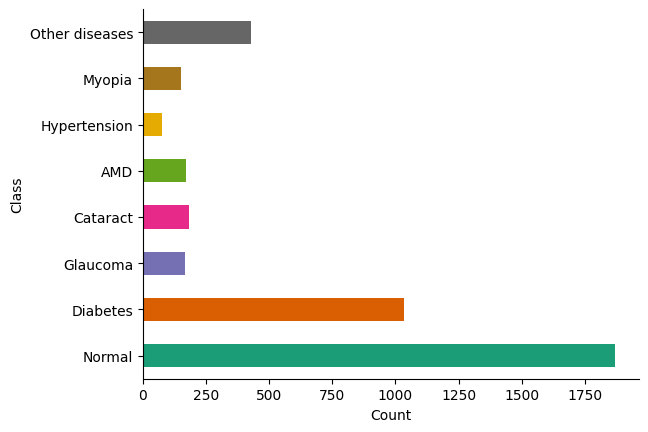

In [5]:
# @title Distribution of Training Data

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
train_df['class_name'] = train_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


class_counts = train_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

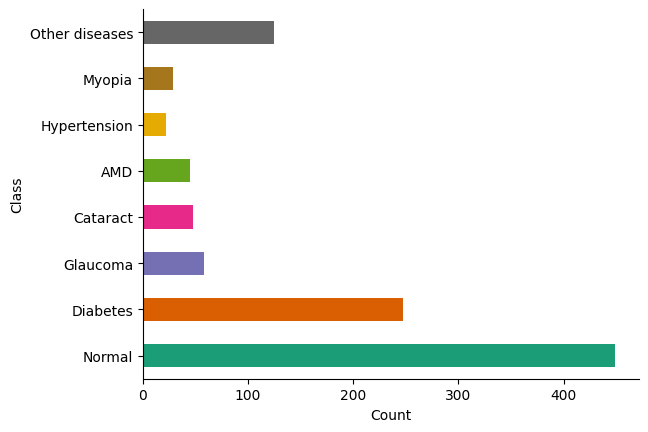

In [6]:
# @title Distribution of Validation Data

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
val_df['class_name'] = val_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


class_counts = val_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

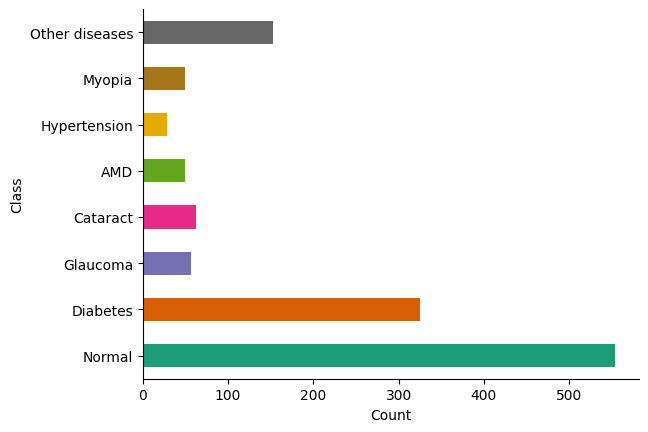

In [7]:
# @title Distribution of Test Data

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
test_df['class_name'] = test_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])

class_counts = test_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

# Data Preparation

## Apply random sampling
- A combination of oversampling and undersampling applied to the data.
- The idea is to balance the data by oversampling the minority class and then undersampling the majority class.


In [8]:

class_distribution = train_df['target'].value_counts()


# Set minimum and maximum thresholds
min_threshold = int(class_distribution.max() * 0.5)  # minimum is half of the largest class size
max_threshold = int(class_distribution.max() * 0.8)  # maximum is 80% of the largest class size

# Determine target samples per class based on conditions
n_samples_per_class = {
    label: max(min_threshold, min(len(df_class), max_threshold)) for label, df_class in train_df.groupby('target')
}

print("Number of samples per class to resample to:", n_samples_per_class)

df_resampled = pd.DataFrame(columns=train_df.columns)

# Upsample or downsample each class according to the specified logic
for class_label, target_count in n_samples_per_class.items():
    df_class = train_df[train_df['target'] == class_label]

    if not df_class.empty:
        # Resample each class to the target count
        df_class_resampled = resample(df_class,
                                      replace=len(df_class) < target_count,  # Sample with replacement if upsampling
                                      n_samples=target_count,  # Target count determined by the logic above
                                      random_state=123)  # For reproducibility
        df_resampled = pd.concat([df_resampled, df_class_resampled])
    else:
        print(f"No samples for class {class_label}. Check your data.")

df_resampled = df_resampled.sample(frac=1, random_state=123).reset_index(drop=True)

Number of samples per class to resample to: {'[0, 0, 0, 0, 0, 0, 0, 1]': 935, '[0, 0, 0, 0, 0, 0, 1, 0]': 935, '[0, 0, 0, 0, 0, 1, 0, 0]': 935, '[0, 0, 0, 0, 1, 0, 0, 0]': 935, '[0, 0, 0, 1, 0, 0, 0, 0]': 935, '[0, 0, 1, 0, 0, 0, 0, 0]': 935, '[0, 1, 0, 0, 0, 0, 0, 0]': 1036, '[1, 0, 0, 0, 0, 0, 0, 0]': 1496}


**Class distribution before sampling**

In [9]:
class_distribution = train_df['target'].value_counts()
print("Class Distribution (Count):\n", class_distribution)


Class Distribution (Count):
 target
[1, 0, 0, 0, 0, 0, 0, 0]    1870
[0, 1, 0, 0, 0, 0, 0, 0]    1036
[0, 0, 0, 0, 0, 0, 0, 1]     430
[0, 0, 0, 1, 0, 0, 0, 0]     183
[0, 0, 0, 0, 1, 0, 0, 0]     171
[0, 0, 1, 0, 0, 0, 0, 0]     169
[0, 0, 0, 0, 0, 0, 1, 0]     153
[0, 0, 0, 0, 0, 1, 0, 0]      78
Name: count, dtype: int64


**Class Distribution after sampling**

In [10]:
class_distribution = df_resampled['target'].value_counts()
print("Class Distribution (Count):\n", class_distribution)

Class Distribution (Count):
 target
[1, 0, 0, 0, 0, 0, 0, 0]    1496
[0, 1, 0, 0, 0, 0, 0, 0]    1036
[0, 0, 0, 0, 0, 0, 1, 0]     935
[0, 0, 0, 0, 0, 1, 0, 0]     935
[0, 0, 0, 0, 1, 0, 0, 0]     935
[0, 0, 0, 0, 0, 0, 0, 1]     935
[0, 0, 1, 0, 0, 0, 0, 0]     935
[0, 0, 0, 1, 0, 0, 0, 0]     935
Name: count, dtype: int64


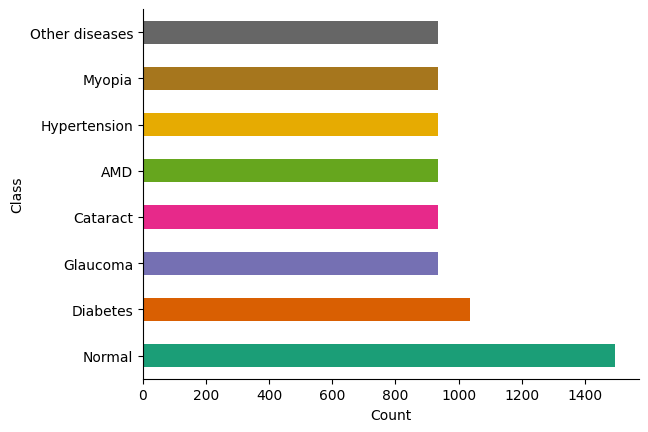

In [11]:
# @title Distribution of Sampled Training Data

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
df_resampled['class_name'] = df_resampled['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = df_resampled['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

##Image Preprocessing

In [12]:
# Function to load and preprocess images
def parse_image_and_label(image_path_left, image_path_right, label_string):
    # 加载左眼图像
    image_left = tf.io.read_file(image_path_left)
    image_left = tf.image.decode_jpeg(image_left, channels=3)
    image_left = tf.cast(image_left, tf.float32)
    image_left = tf.keras.applications.resnet50.preprocess_input(image_left)

    # 加载右眼图像
    image_right = tf.io.read_file(image_path_right)
    image_right = tf.image.decode_jpeg(image_right, channels=3)
    image_right = tf.cast(image_right, tf.float32)
    image_right = tf.keras.applications.resnet50.preprocess_input(image_right)

    # 合并图像，例如：水平拼接
    image = tf.concat([image_left, image_right], axis=1)

    # 调整合并图像的大小
    image = tf.image.resize(image, [224, 448])

    # 处理标签 (保持原样)
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

Preparing Train, Test and Validation Datasets

In [13]:
def file_exists(file_paths):
    # Filter out non-existing files
    return [file_path for file_path in file_paths if os.path.exists(file_path)]

def load_and_prepare_dataset(df, images_dir, shuffle=True, batch_size=32):
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    labels = df['target'].values  # Only one set of labels is needed

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images_left, images_right, labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset

In [14]:
train_ds = load_and_prepare_dataset(df_resampled, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=True, batch_size=16)
test_ds = load_and_prepare_dataset(test_df, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=False, batch_size=16)
val_ds = load_and_prepare_dataset(val_df, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=False, batch_size=16)


Size of Datasets

In [15]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))
print("size of testing dataset: ", len(test_ds) )

size of training dataset:  509
size of validation dataset:  64
size of testing dataset:  80


# Visualising the training and validation datasets




In [16]:
# import gc
# import tensorflow as tf

# print("Training dataset")

# plt.figure(figsize=(10, 10))

# # 迭代 train_ds，每次获取一个批次
# for batch_images, batch_labels in train_ds.take(1):
#   # 迭代批次中的图像和标签
#   for i in range(min(9, batch_images.shape[0])):  # 只处理前 9 张图像或批次中的所有图像
#       ax = plt.subplot(3, 3, i + 1)

#       # 从批次中获取单个图像，并进行反归一化
#       image = batch_images[i].numpy()
#       # 如果图像是合并后的图像，则需要调整显示方式
#       # 例如，如果图像是水平拼接的，则需要调整宽度
#       plt.imshow(image.astype("uint8"))

#       class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
#       class_index = np.argmax(batch_labels[i].numpy())
#       plt.title(class_names[class_index])
#       plt.axis("off")

#       # 立即释放图像占用的内存
#       del image
#       gc.collect()

# plt.show()
# plt.close()  # 关闭绘图窗口

# tf.keras.backend.clear_session()  # 清除 TensorFlow 会话

In [17]:
# import gc  # 用于垃圾回收

# print("Training dataset")

# # 使用生成器按需加载数据
# for i, (images, labels) in enumerate(train_ds.take(1)):  # 只取前 1 个批次
#     for j in range(min(9, images.shape[0])):  # 迭代批次中的每个图像，最多迭代 9 个
#         ax = plt.subplot(3, 3, j + 1)  # 调整子图布局
#         # 反归一化图像数据
#         image = images[j].numpy()  # 获取单个图像
#         # 调整图像大小
#         image = tf.image.resize(image, [112, 224]) # 将图像大小调整为 (112, 224)
#         image = image.numpy().astype("uint8")  # 转换为 uint8 类型
#         # 如果图像是合并后的图像，则需要调整显示方式
#         # 例如，如果图像是水平拼接的，则需要调整宽度
#         plt.imshow(image)
#         class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
#         class_index = np.argmax(labels[j].numpy())  # 获取单个图像的标签
#         plt.title(class_names[class_index])
#         plt.axis("off")

#         # 释放内存
#         del image
#         gc.collect()

# plt.show()

# Training the model

In [20]:
# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model.keras', verbose=1, save_best_only=True)  # 修改 filepath
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


callbacks = [early_stopping, checkpoint, reduce_lr]

In [23]:
from tensorflow.keras import layers, Model, Input

# 加载预训练模型
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),  # 保持预训练模型的输入形状不变
    pooling='avg',
    weights='imagenet')

# 冻结预训练模型的层
for layer in pretrained_model.layers:
    layer.trainable = False

# 定义输入层
input_tensor = Input(shape=(224, 448, 3))  # 合并后的图像形状

# 添加自定义层，将合并后的图像拆分为左右眼图像
left_eye = layers.Cropping2D(((0, 0), (0, 224)))(input_tensor)  # 左眼图像
right_eye = layers.Cropping2D(((0, 0), (224, 0)))(input_tensor)  # 右眼图像

# 将左右眼图像分别传递给预训练模型
left_features = pretrained_model(left_eye)
right_features = pretrained_model(right_eye)

# 合并左右眼特征
merged_features = layers.concatenate([left_features, right_features])

# 添加全连接层、Dropout 层和输出层
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(merged_features)
x = layers.Dropout(0.2)(x)
output_tensor = layers.Dense(8, activation='softmax')(x)

# 创建模型
model = Model(inputs=input_tensor, outputs=output_tensor)

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 448, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cropping2d (Cropping2D)   │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cropping2d_1 (Cropping2D) │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 2048)           │     23,587,712 │ cropping2d[0][0],      │
│                           │                        │                │ cropping2d_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 4096)           │              0 │ resnet50[0][0],        │
│                           │                        │                │ resnet50[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      2,097,664 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 8)              │          4,104 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,689,480 (98.00 MB)

 Trainable params: 2,101,768 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

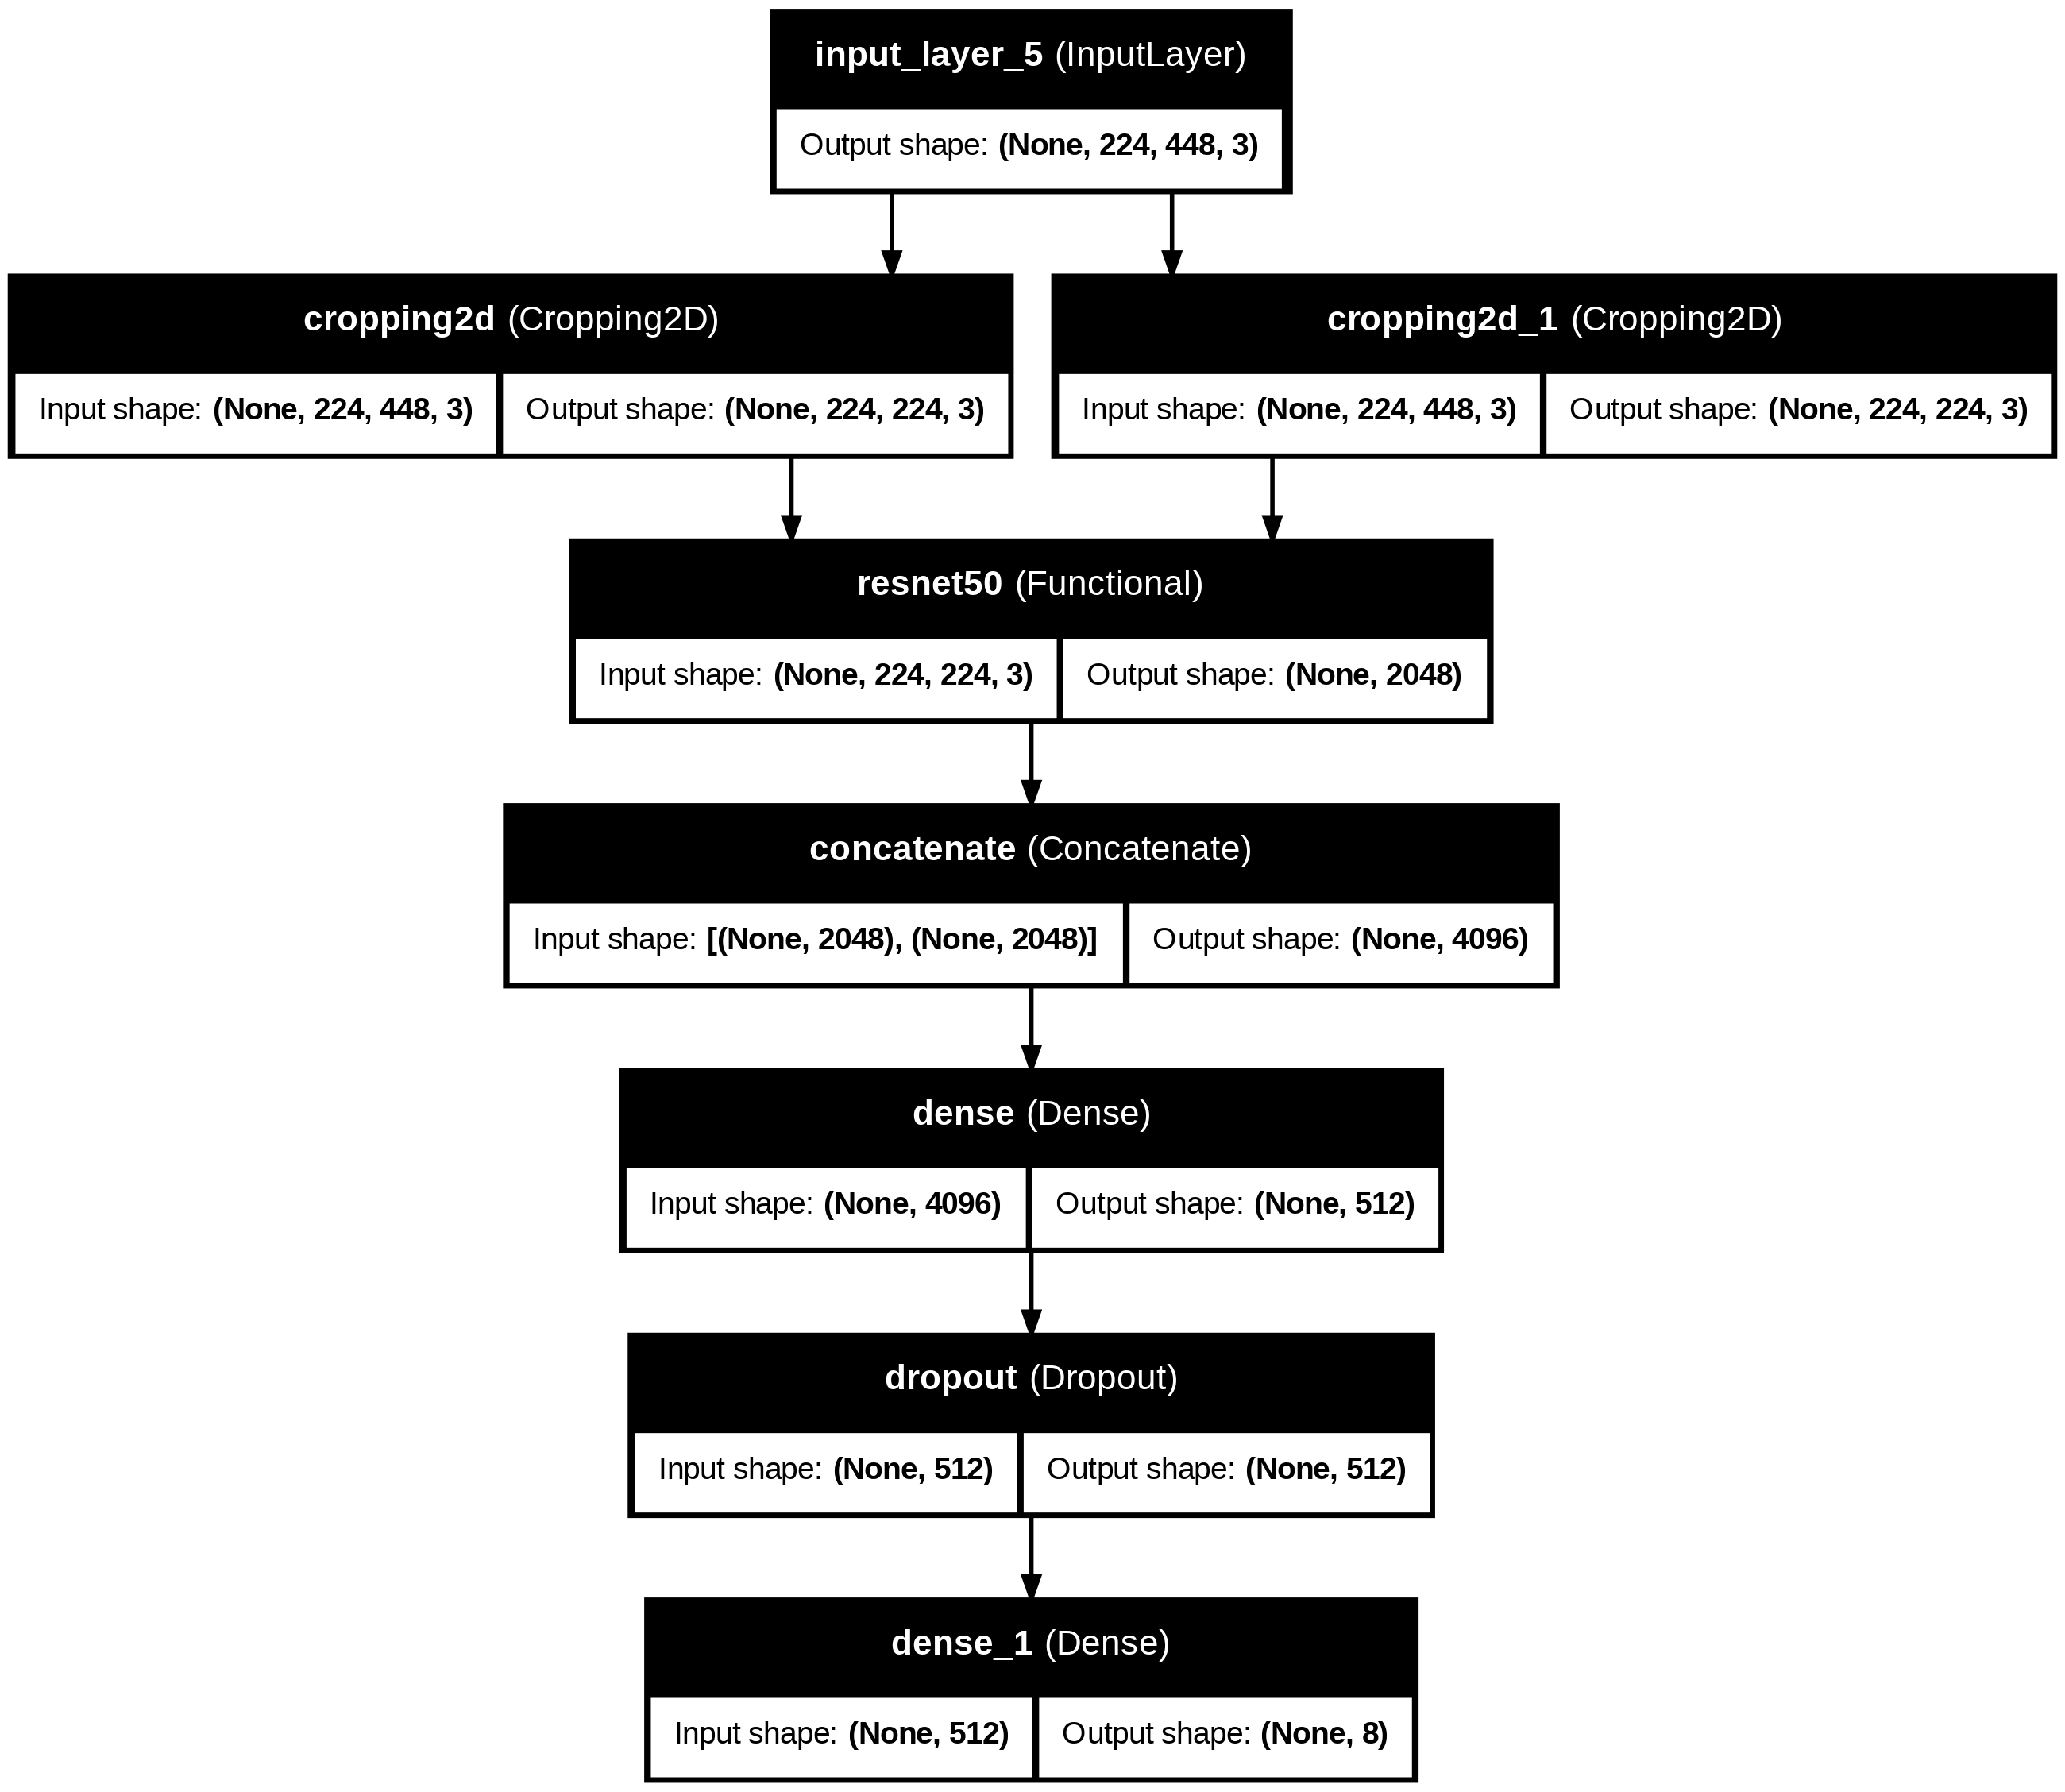

In [25]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 80
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/80


## Using KerasTuner
- To find the best hyperparameter values for model
```
@misc{omalley2019kerastuner,
    title        = {KerasTuner},
    author       = {O'Malley, Tom and Bursztein, Elie and Long, James and Chollet, Fran\c{c}ois and Jin, Haifeng and Invernizzi, Luca and others},
    year         = 2019,
    howpublished = {\url{https://github.com/keras-team/keras-tuner}}
}
```



In [ ]:
pip install keras-tuner --upgrade

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Dropout, Input, Cropping2D, concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def model_builder(hp):
    # 加载预训练模型
    pretrained_model = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=(224, 224, 3),  # 保持预训练模型的输入形状不变
        pooling='avg',
        weights='imagenet'
    )

    # 冻结预训练模型的层
    for layer in pretrained_model.layers:
        layer.trainable = False

    # 定义输入层
    input_tensor = Input(shape=(224, 448, 3))  # 合并后的图像形状

    # 添加自定义层，将合并后的图像拆分为左右眼图像
    left_eye = Cropping2D(((0, 0), (0, 224)))(input_tensor)  # 左眼图像
    right_eye = Cropping2D(((0, 0), (224, 0)))(input_tensor)  # 右眼图像

    # 将左右眼图像分别传递给预训练模型
    left_features = pretrained_model(left_eye)
    right_features = pretrained_model(right_eye)

    # 合并左右眼特征
    merged_features = concatenate([left_features, right_features])

    # 添加全连接层、Dropout 层和输出层
    hp_units = hp.Int('units', min_value=128, max_value=512, step=64)  # 可调单元数
    x = Dense(hp_units, activation='relu', kernel_regularizer=l2(0.001))(merged_features)

    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)  # 可调丢弃率
    x = Dropout(hp_dropout)(x)

    output_tensor = Dense(8, activation='softmax')(x)

    # 创建模型
    model = Model(inputs=input_tensor, outputs=output_tensor)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='tuning',
                     project_name='resnet50_tuning')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Replace 'train_ds' and 'val_ds' with your actual training and validation datasets
tuner.search(train_ds, validation_data=val_ds, epochs=2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
# Building the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Again, replace 'train_ds' and 'val_ds' with your actual datasets
history = model.fit(train_ds, validation_data=val_ds, epochs=80, callbacks=[callbacks])

# Evaluating Model
- Model Accuracy
- Model Loss


In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Finetuning

In [ ]:
# dictionary to store training history
full_history = {}

# Function to unfreeze layers gradually 1-4
def unfreeze_model(model, pretrained_model, n_layers):
    # Unfreeze the top `n_layers` of the pretrained model
    for layer in pretrained_model.layers[-n_layers:]:
        layer.trainable = True

    # Recompile the model every time change is made to layer's `trainable` status
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Gradually unfreeze the layers and save history
for i in range(1, 5):  #  unfreeze the top 4 layers one by one
    print(f"Unfreezing top {i} layers and retraining.")
    unfreeze_model(model, pretrained_model, i)

    history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

    # Save the history in the full_history dictionary
    full_history[f'phase_{i}'] = history.history

    # Save the model at each phase
    model.save(f'model_after_unfreezing_{i}_layers.h5')


# Evaluating Model
- Model Accuracy
- Model Loss


In [ ]:
# Function to plot accuracy and loss
def plot_history(full_history):
    # Initialize lists for the plot
    acc, val_acc, loss, val_loss = [], [], [], []

    # Aggregate the history data
    for phase, history in full_history.items():
        acc += history['accuracy']
        val_acc += history['val_accuracy']
        loss += history['loss']
        val_loss += history['val_loss']

    # Plotting
    plt.figure(figsize=(16, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(full_history)


# Making Predictions


In [ ]:
test_ds.take(1)

# Evaluating the model on the test set
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {round(accuracy * 100, 2)}%')

In [ ]:
# Evaluate the model on the test dataset
evaluation_results =model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

num_images_to_display = 9

# lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(20, 10))  # 调整图形大小以适应更宽的图像
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))  # 不需要修改
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Prediction Evaluation


In [ ]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report

In [ ]:
for _, label in test_ds.unbatch().take(1):
    print("Unbatched label shape:", label.numpy().shape)
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

In [ ]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)

Balanced Accuracy Score

In [ ]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Area Under the Reciever Operating Characteristic Curve (AUC-ROC)


In [ ]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

Confusion Matrix

In [ ]:

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Normalised Confusion Matrix

In [ ]:
# Calculate normalized confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = cm.astype('float') / cm.sum()

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()